<a href="https://colab.research.google.com/github/yashguptaab99/Semantic-Segmentation/blob/master/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!git clone "https://github.com/yashguptaab99/Semantic-Segmentation.git"

Cloning into 'Semantic-Segmentation'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 26 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [2]:
import sys
sys.path.append('/content/Semantic-Segmentation')
import os
import numpy as np
from config import model_name, n_classes, imshape, labels, hues, mode
from models import unet, fcn_8
from data_generator import DataGenerator
from PIL import Image
from tensorflow.keras.utils import to_categorical
import json

# Data Preparation

In [3]:
def generate_missing_json():

    # creates a background json for the entire image if missing
    # this assumes you will never annotate a background class

    for im in os.listdir('drive/My Drive/Projects/Semantic-Shapes-master/images'):
        fn = im.split('.')[0]+'.json'
        path = os.path.join('drive/My Drive/Projects/Semantic-Shapes-master/annotated', fn)

        if os.path.exists(path) is False:
            json_dict = {}

            # these points might be reversed if not using a square image (idk)
            json_dict['shapes'] = [{"label": "background",
                                    "points": [[0,0],
                                               [0, imshape[0]-1],
                                               [imshape[0]-1, imshape[1]-1],
                                               [imshape[0]-1, 0]]
                                    }]
            with open(path, 'w') as handle:
                json.dump(json_dict, handle, indent=2)

In [4]:
def sorted_fns(dir):
    return sorted(os.listdir(dir), key=lambda x: int(x.split('.')[0]))

## Some images contains no Masala packet so no annotated jason file so we have to create backgroung json file
if len(os.listdir('drive/My Drive/Projects/Semantic-Shapes-master/images')) != len(os.listdir('drive/My Drive/Projects/Semantic-Shapes-master/annotated')):
    generate_missing_json()

In [5]:
image_paths = [os.path.join('drive/My Drive/Projects/Semantic-Shapes-master/images', x) for x in sorted_fns('/content/drive/My Drive/Projects/Semantic-Shapes-master/images')]
annot_paths = [os.path.join('drive/My Drive/Projects/Semantic-Shapes-master/annotated', x) for x in sorted_fns('/content/drive/My Drive/Projects/Semantic-Shapes-master/annotated')]

## Creating Masks of input images and Data Augmentation

In [6]:
tg = DataGenerator(image_paths=image_paths, annot_paths=annot_paths,
                   batch_size=5, augment=True)

# Model

In [7]:
model = fcn_8(pretrained=False, base=5)

Model: "fcn_8multi"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 32) 9248        block1_conv1[0][0]               
_________________________________________________________________________________________

In [8]:
history = model.fit_generator(generator=tg,
                    steps_per_epoch=len(tg),
                    epochs=500, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500
37/37 [==============================] - 315s 9s/step - loss: 1.3596 - dice: 0.2535
Epoch 2/500
37/37 [==============================] - 10s 270ms/step - loss: 1.3225 - dice: 0.2686
Epoch 3/500
37/37 [==============================] - 4s 109ms/step - loss: 1.2629 - dice: 0.2991
Epoch 4/500
37/37 [==============================] - 4s 108ms/step - loss: 1.1764 - dice: 0.3475
Epoch 5/500
37/37 [==============================] - 4s 109ms/step - loss: 1.0667 - dice: 0.4092
Epoch 6/500
37/37 [==============================] - 4s 109ms/step - loss: 0.9571 - dice: 0.4678
Epoch 7/500
37/37 [==============================] - 4s 109ms/step - loss: 0.8459 - dice: 0.5381
Epoch 8/500
37/37 [==============================] - 4s 110ms/step - loss: 0.7411 - dice: 0.5953
Epoch 9/500
37/37 [==============================] - 4s 111ms/step - loss: 0.6624 - dice: 0.6426
Epoch 10/500
37/37 [==============================]

# Output

## Mask Functions

In [9]:
def add_masks(pred):
    blank = np.zeros(shape=imshape, dtype=np.uint8)

    for i, label in enumerate(labels):

        hue = np.full(shape=(imshape[0], imshape[1]), fill_value=hues[label], dtype=np.uint8)
        sat = np.full(shape=(imshape[0], imshape[1]), fill_value=255, dtype=np.uint8)
        val = pred[:,:,i].astype(np.uint8)

        im_hsv = cv2.merge([hue, sat, val])
        im_rgb = cv2.cvtColor(im_hsv, cv2.COLOR_HSV2RGB)
        blank = cv2.add(blank, im_rgb)

    return blank

### Conditional Random Fields (CFR)

In [10]:
pip install pydensecrf

     |████████████████████████████████| 1.0MB 8.6MB/s 
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc3-cp36-cp36m-linux_x86_64.whl size=2153743 sha256=ec7b77c0a9615c7c5df8ee57dbf3b2f29397bc3d959c6f09d06361397011f1f4
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


In [11]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax
def crf(im_softmax, im_rgb):
    n_classes = im_softmax.shape[2]
    feat_first = im_softmax.transpose((2, 0, 1)).reshape(n_classes, -1)
    unary = unary_from_softmax(feat_first)
    unary = np.ascontiguousarray(unary)
    im_rgb = np.ascontiguousarray(im_rgb)

    d = dcrf.DenseCRF2D(im_rgb.shape[1], im_rgb.shape[0], n_classes)

    d.setUnaryEnergy(unary)
    d.addPairwiseGaussian(sxy=(5, 5), compat=3, kernel=dcrf.DIAG_KERNEL,
                              normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(5, 5), srgb=(13, 13, 13), rgbim=im_rgb,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(5)
    res = np.argmax(Q, axis=0).reshape((im_rgb.shape[0], im_rgb.shape[1]))
    if mode is 'binary':
        return res * 255.0
    if mode is 'multi':
        res_hot = to_categorical(res) * 255.0
        res_crf = add_masks(res_hot)
        return res_crf

## Output Result
We can see CFR is giving better result

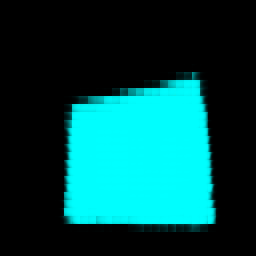

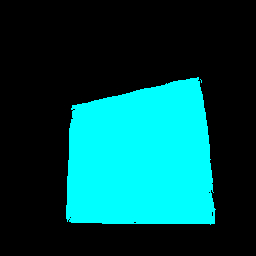

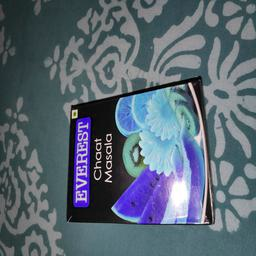

True

In [13]:
import cv2
from google.colab.patches import cv2_imshow
path = '/content/Semantic-Segmentation/test2.jpg'
im = cv2.imread(path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256), interpolation = cv2.INTER_AREA)
tm = np.expand_dims(im, axis=0)
im_pred = model.predict(tm)
im_mask1 = add_masks(im_pred.squeeze()*255.0)
im_mask2 = crf(im_pred.squeeze(), im)
cv2_imshow(im_mask1)
cv2_imshow(im_mask2)
cv2_imshow(im)
cv2.imwrite("/content/Semantic-Segmentation/output2.jpg", im_mask2)

# Assigning White Background

## Taking input

In [14]:
bg = cv2.imread("/content/Semantic-Segmentation/background.jpg")
bg = cv2.resize(bg, (256, 256), interpolation = cv2.INTER_AREA)

fg = cv2.imread("/content/Semantic-Segmentation/test2.jpg")
fg = cv2.resize(fg, (256, 256), interpolation = cv2.INTER_AREA)

mask = cv2.imread("/content/Semantic-Segmentation/output2.jpg",0)
mask = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_AREA)
ret, mask = cv2.threshold(mask, 15, 255, cv2.THRESH_BINARY)

mask2 = mask.copy()
fg2 = fg.copy()
bg2 = bg.copy()

print('Mask : ',mask2.shape)
print('FG : ',fg2.shape)
print('BG : ',bg.shape)

Mask :  (256, 256)
FG :  (256, 256, 3)
BG :  (256, 256, 3)


## Data Preparation

In [15]:
#RESIZE IMAGE BY WIDTH OR HEIGHT MAINTAINING ASPECT RATIO
def maintain_aspect_ratio_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Grab the image size and initialize dimensions
    dim = None
    (h, w) = image.shape[:2]

    # Return original image if no need to resize
    if width is None and height is None:
        return image

    # We are resizing height if width is none
    if width is None:
        # Calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # We are resizing width if height is none
    else:
        # Calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Return the resized image
    return cv2.resize(image, dim, interpolation=inter)

In [16]:
#openCV places height before width in shape[] array

bgWidth = bg2.shape[1]
bgHeight = bg2.shape[0]

fgWidth = fg2.shape[1]
fgHeight = fg2.shape[0]

fg2 = maintain_aspect_ratio_resize(fg2, width=bgWidth)
mask2 = maintain_aspect_ratio_resize(mask2, width=bgWidth)

fgWidth = fg2.shape[1]
fgHeight = fg2.shape[0]

if fgHeight > bgHeight:
  fg2 = maintain_aspect_ratio_resize(fg2, height=bgHeight)
  mask2 = maintain_aspect_ratio_resize(mask2, height=bgHeight)

In [17]:
print('Mask : ',mask2.shape)
print('FG : ',fg2.shape)
print('BG : ',bg.shape)

Mask :  (256, 256)
FG :  (256, 256, 3)
BG :  (256, 256, 3)


## Implement 

In [18]:
alpha = cv2.GaussianBlur(mask2, (21,21),0)
bg2[np.where(alpha > 150)] = fg2[np.where(alpha > 150)]
output = bg2.copy()

## Result

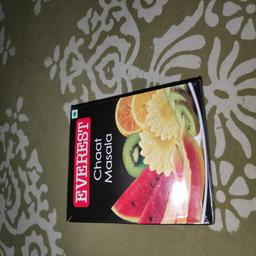

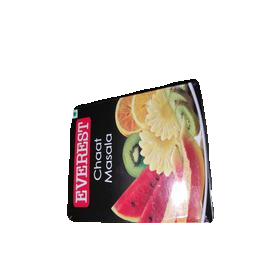

In [19]:
cv2_imshow(fg)
cv2_imshow(output)

In [20]:
cv2.imwrite("/content/Semantic-Segmentation/Whiteoutput1.jpg", output)

True